## Configurações

In [146]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from textblob import TextBlob
from scipy import stats
from scipy.stats import pearsonr, f_oneway
import statsmodels.api as sm
from statsmodels.formula.api import ols
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
from sklearn.metrics.pairwise import cosine_similarity
from wordcloud import WordCloud
import joblib

## Carregamento e limpeza dos dados

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Supondo que temos um arquivo CSV chamado 'filmes.csv'
dados = pd.read_csv('/content/drive/My Drive/Desafio Indicium/desafio_indicium_imdb.csv')

In [4]:
# Visualização das primeiras linhas do dataset
print(dados.head())

   Unnamed: 0                                   Series_Title Released_Year  \
0           1                                  The Godfather          1972   
1           2                                The Dark Knight          2008   
2           3                         The Godfather: Part II          1974   
3           4                                   12 Angry Men          1957   
4           5  The Lord of the Rings: The Return of the King          2003   

  Certificate  Runtime                     Genre  IMDB_Rating  \
0           A  175 min              Crime, Drama          9.2   
1          UA  152 min      Action, Crime, Drama          9.0   
2           A  202 min              Crime, Drama          9.0   
3           U   96 min              Crime, Drama          9.0   
4           U  201 min  Action, Adventure, Drama          8.9   

                                            Overview  Meta_score  \
0  An organized crime dynasty's aging patriarch t...       100.0   
1  W

In [5]:
# Informações gerais sobre o dataset
print(dados.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     999 non-null    int64  
 1   Series_Title   999 non-null    object 
 2   Released_Year  999 non-null    object 
 3   Certificate    898 non-null    object 
 4   Runtime        999 non-null    object 
 5   Genre          999 non-null    object 
 6   IMDB_Rating    999 non-null    float64
 7   Overview       999 non-null    object 
 8   Meta_score     842 non-null    float64
 9   Director       999 non-null    object 
 10  Star1          999 non-null    object 
 11  Star2          999 non-null    object 
 12  Star3          999 non-null    object 
 13  Star4          999 non-null    object 
 14  No_of_Votes    999 non-null    int64  
 15  Gross          830 non-null    object 
dtypes: float64(2), int64(2), object(12)
memory usage: 125.0+ KB
None


In [6]:
# Estatísticas descritivas
print(dados.describe())

       Unnamed: 0  IMDB_Rating  Meta_score   No_of_Votes
count  999.000000   999.000000  842.000000  9.990000e+02
mean   500.000000     7.947948   77.969121  2.716214e+05
std    288.530761     0.272290   12.383257  3.209126e+05
min      1.000000     7.600000   28.000000  2.508800e+04
25%    250.500000     7.700000   70.000000  5.547150e+04
50%    500.000000     7.900000   79.000000  1.383560e+05
75%    749.500000     8.100000   87.000000  3.731675e+05
max    999.000000     9.200000  100.000000  2.303232e+06


In [7]:
# Verificação de dados faltantes
print(dados.isnull().sum())

Unnamed: 0         0
Series_Title       0
Released_Year      0
Certificate      101
Runtime            0
Genre              0
IMDB_Rating        0
Overview           0
Meta_score       157
Director           0
Star1              0
Star2              0
Star3              0
Star4              0
No_of_Votes        0
Gross            169
dtype: int64


In [8]:
dados['Gross'] = dados['Gross'].str.replace(',', '').astype(float)

In [9]:
dados['Gross'].fillna(0, inplace=True)

In [10]:
dados['Runtime'] = dados['Runtime'].str.replace('min', '').astype(int)

In [11]:
dados['Released_Year'] = pd.to_numeric(dados['Released_Year'], errors='coerce').astype('Int64')

In [12]:
dados['Certificate'].fillna('Unrated', inplace=True)

In [13]:
dados['Meta_score'].fillna(dados['Meta_score'].mean(), inplace=True)

In [14]:
dados

Unnamed: 0                                   Series_Title  Released_Year  \
0             1                                  The Godfather           1972   
1             2                                The Dark Knight           2008   
2             3                         The Godfather: Part II           1974   
3             4                                   12 Angry Men           1957   
4             5  The Lord of the Rings: The Return of the King           2003   
..          ...                                            ...            ...   
994         995                         Breakfast at Tiffany's           1961   
995         996                                          Giant           1956   
996         997                          From Here to Eternity           1953   
997         998                                       Lifeboat           1944   
998         999                                   The 39 Steps           1935   

    Certificate  Runtime                     Genre  IMDB_Rating  \
0             A      175              Crime, Drama          9.2   
1            UA      152      Action, Crime, Drama          9.0   
2             A      202              Crime, Drama          9.0   
3             U       96              Crime, Drama          9.0   
4             U      201  Action, Adventure, Drama          8.9   
..          ...      ...                       ...          ...   
994           A      115    Comedy, Drama, Romance          7.6   
995           G      201            Drama, Western          7.6   
996      Passed      118       Drama, Romance, War          7.6   
997     Unrated       97                Drama, War          7.6   
998     Unrated       86  Crime, Mystery, Thriller          7.6   

                                              Overview  Meta_score  \
0    An organized crime dynasty's aging patriarch t...       100.0   
1    When the menace known as the Joker wreaks havo...        84.0   
2    The early life and career of Vito Corleone in ...        90.0   
3    A jury holdout attempts to prevent a miscarria...        96.0   
4    Gandalf and Aragorn lead the World of Men agai...        94.0   
..                                                 ...         ...   
994  A young New York socialite becomes interested ...        76.0   
995  Sprawling epic covering the life of a Texas ca...        84.0   
996  In Hawaii in 1941, a private is cruelly punish...        85.0   
997  Several survivors of a torpedoed merchant ship...        78.0   
998  A man in London tries to help a counter-espion...        93.0   

                 Director              Star1              Star2  \
0    Francis Ford Coppola      Marlon Brando          Al Pacino   
1       Christopher Nolan     Christian Bale       Heath Ledger   
2    Francis Ford Coppola          Al Pacino     Robert De Niro   
3            Sidney Lumet        Henry Fonda        Lee J. Cobb   
4           Peter Jackson        Elijah Wood    Viggo Mortensen   
..                    ...                ...                ...   
994         Blake Edwards     Audrey Hepburn     George Peppard   
995        George Stevens   Elizabeth Taylor        Rock Hudson   
996        Fred Zinnemann     Burt Lancaster   Montgomery Clift   
997      Alfred Hitchcock  Tallulah Bankhead        John Hodiak   
998      Alfred Hitchcock       Robert Donat  Madeleine Carroll   

              Star3           Star4  No_of_Votes        Gross  
0        James Caan    Diane Keaton      1620367  134966411.0  
1     Aaron Eckhart   Michael Caine      2303232  534858444.0  
2     Robert Duvall    Diane Keaton      1129952   57300000.0  
3     Martin Balsam    John Fiedler       689845    4360000.0  
4      Ian McKellen   Orlando Bloom      1642758  377845905.0  
..              ...             ...          ...          ...  
994   Patricia Neal     Buddy Ebsen       166544          0.0  
995      James Dean   Carroll Baker        34075          0.0  
996  

In [15]:
# Verificação após a limpeza
print(dados.isnull().sum())

Unnamed: 0       0
Series_Title     0
Released_Year    1
Certificate      0
Runtime          0
Genre            0
IMDB_Rating      0
Overview         0
Meta_score       0
Director         0
Star1            0
Star2            0
Star3            0
Star4            0
No_of_Votes      0
Gross            0
dtype: int64


In [16]:
# Remover linhas com valores faltantes em Released_Year
dados.dropna(subset=['Released_Year'], inplace=True)


In [17]:
dados = dados.drop(columns=['Unnamed: 0'])

In [18]:
print(dados.info())

<class 'pandas.core.frame.DataFrame'>
Index: 998 entries, 0 to 998
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Series_Title   998 non-null    object 
 1   Released_Year  998 non-null    Int64  
 2   Certificate    998 non-null    object 
 3   Runtime        998 non-null    int64  
 4   Genre          998 non-null    object 
 5   IMDB_Rating    998 non-null    float64
 6   Overview       998 non-null    object 
 7   Meta_score     998 non-null    float64
 8   Director       998 non-null    object 
 9   Star1          998 non-null    object 
 10  Star2          998 non-null    object 
 11  Star3          998 non-null    object 
 12  Star4          998 non-null    object 
 13  No_of_Votes    998 non-null    int64  
 14  Gross          998 non-null    float64
dtypes: Int64(1), float64(3), int64(2), object(9)
memory usage: 125.7+ KB
None


##Análise univariada

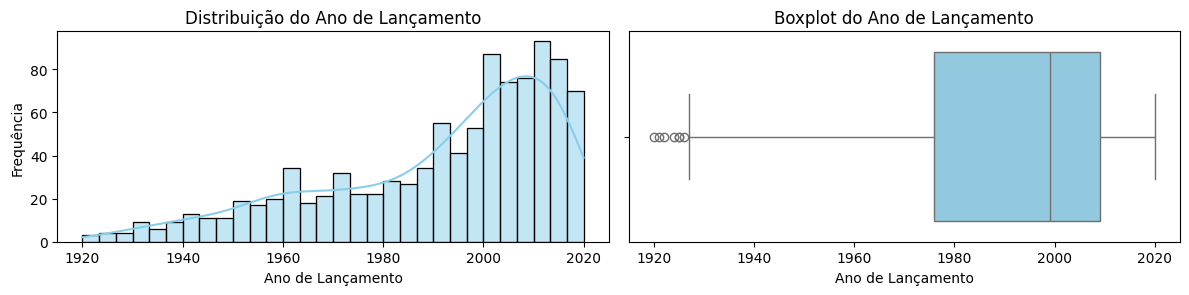

In [19]:
plt.figure(figsize=(12, 8))

# Distribuição da variável Released_Year
plt.subplot(3, 2, 1)
sns.histplot(dados['Released_Year'], kde=True, bins=30, color='skyblue')
plt.title('Distribuição do Ano de Lançamento')
plt.xlabel('Ano de Lançamento')
plt.ylabel('Frequência')

# Boxplot da variável Released_Year
plt.subplot(3, 2, 2)
sns.boxplot(x=dados['Released_Year'], color='skyblue')
plt.title('Boxplot do Ano de Lançamento')
plt.xlabel('Ano de Lançamento')

plt.tight_layout()
plt.show()


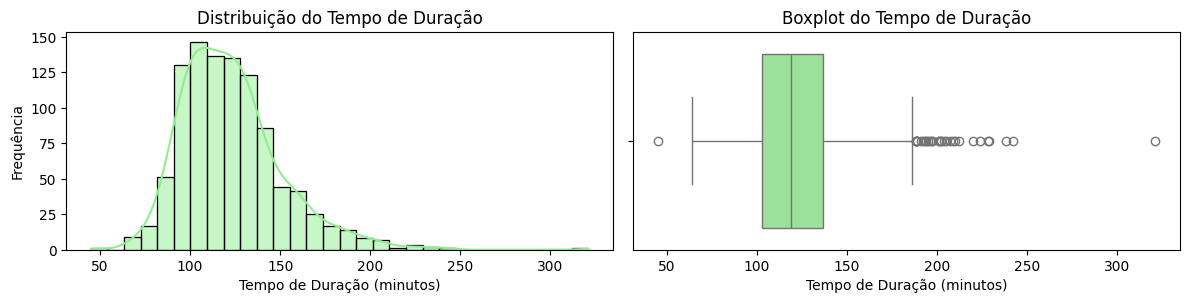

In [20]:
plt.figure(figsize=(12, 8))

# Distribuição da variável Runtime
plt.subplot(3, 2, 3)
sns.histplot(dados['Runtime'], kde=True, bins=30, color='lightgreen')
plt.title('Distribuição do Tempo de Duração')
plt.xlabel('Tempo de Duração (minutos)')
plt.ylabel('Frequência')

# Boxplot da variável Runtime
plt.subplot(3, 2, 4)
sns.boxplot(x=dados['Runtime'], color='lightgreen')
plt.title('Boxplot do Tempo de Duração')
plt.xlabel('Tempo de Duração (minutos)')

plt.tight_layout()
plt.show()

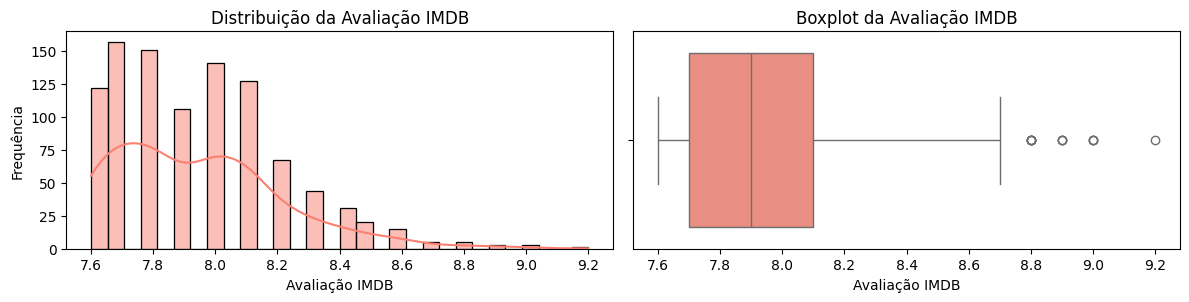

In [21]:
plt.figure(figsize=(12, 8))

# Distribuição da variável IMDB_Rating
plt.subplot(3, 2, 5)
sns.histplot(dados['IMDB_Rating'], kde=True, bins=30, color='salmon')
plt.title('Distribuição da Avaliação IMDB')
plt.xlabel('Avaliação IMDB')
plt.ylabel('Frequência')

# Boxplot da variável IMDB_Rating
plt.subplot(3, 2, 6)
sns.boxplot(x=dados['IMDB_Rating'], color='salmon')
plt.title('Boxplot da Avaliação IMDB')
plt.xlabel('Avaliação IMDB')

plt.tight_layout()
plt.show()

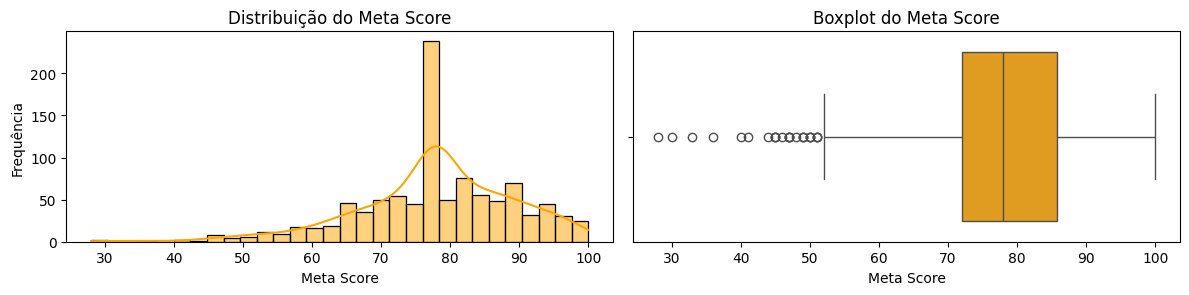

In [23]:
plt.figure(figsize=(12, 8))


# Distribuição da variável Meta_score
plt.subplot(3, 2, 1)
sns.histplot(dados['Meta_score'], kde=True, bins=30, color='orange')
plt.title('Distribuição do Meta Score')
plt.xlabel('Meta Score')
plt.ylabel('Frequência')

# Boxplot da variável Meta_score
plt.subplot(3, 2, 2)
sns.boxplot(x=dados['Meta_score'], color='orange')
plt.title('Boxplot do Meta Score')
plt.xlabel('Meta Score')

plt.tight_layout()
plt.show()

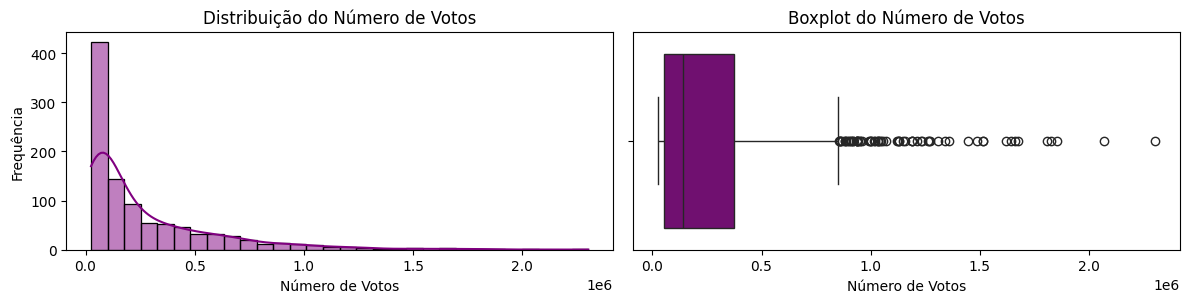

In [24]:
plt.figure(figsize=(12, 8))


# Distribuição da variável No_of_Votes
plt.subplot(3, 2, 3)
sns.histplot(dados['No_of_Votes'], kde=True, bins=30, color='purple')
plt.title('Distribuição do Número de Votos')
plt.xlabel('Número de Votos')
plt.ylabel('Frequência')

# Boxplot da variável No_of_Votes
plt.subplot(3, 2, 4)
sns.boxplot(x=dados['No_of_Votes'], color='purple')
plt.title('Boxplot do Número de Votos')
plt.xlabel('Número de Votos')

plt.tight_layout()
plt.show()

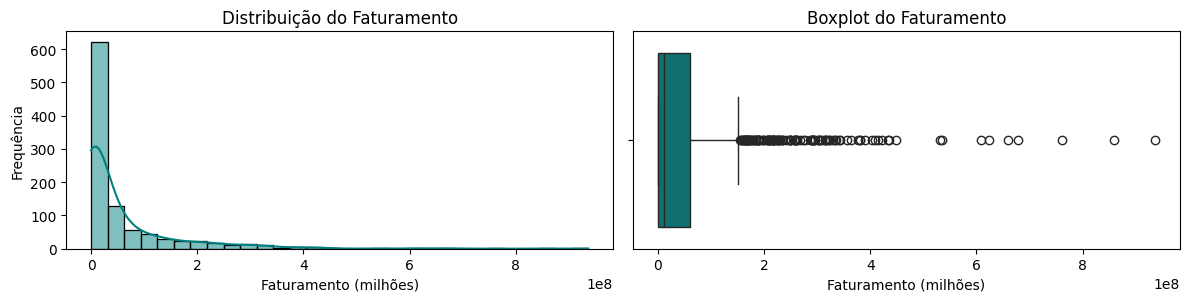

In [25]:
plt.figure(figsize=(12, 8))

# Distribuição da variável Gross
plt.subplot(3, 2, 5)
sns.histplot(dados['Gross'], kde=True, bins=30, color='teal')
plt.title('Distribuição do Faturamento')
plt.xlabel('Faturamento (milhões)')
plt.ylabel('Frequência')

# Boxplot da variável Gross
plt.subplot(3, 2, 6)
sns.boxplot(x=dados['Gross'], color='teal')
plt.title('Boxplot do Faturamento')
plt.xlabel('Faturamento (milhões)')

plt.tight_layout()
plt.show()

<ipython-input-26-71eea4b0648f>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=certificate_counts.index, y=certificate_counts.values, palette='viridis')


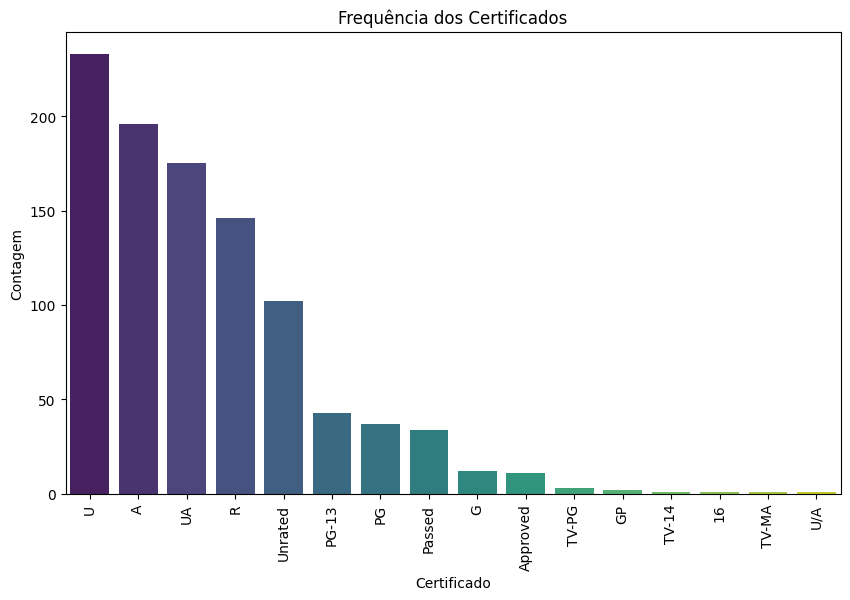

In [26]:
certificate_counts = dados['Certificate'].value_counts()

# Plot para a frequência dos Certificados
plt.figure(figsize=(10, 6))
sns.barplot(x=certificate_counts.index, y=certificate_counts.values, palette='viridis')
plt.title('Frequência dos Certificados')
plt.xlabel('Certificado')
plt.ylabel('Contagem')
plt.xticks(rotation=90)
plt.show()

<ipython-input-27-01d57bafd346>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=director_counts.index, y=director_counts.values, palette='viridis')


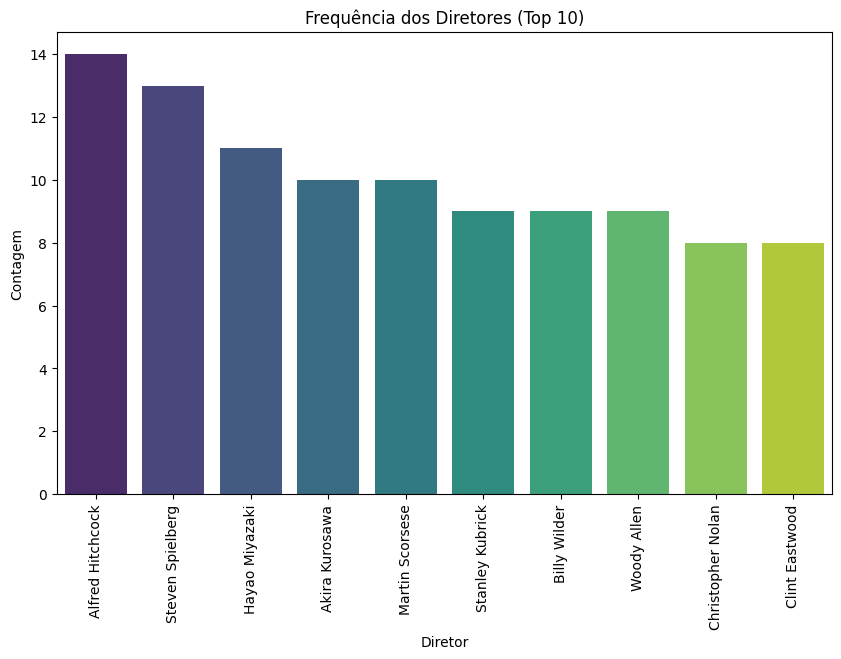

In [27]:
director_counts = dados['Director'].value_counts().head(10)  # Mostrar apenas os 10 diretores mais frequentes

# Plot para a frequência dos Diretores (Top 10)
plt.figure(figsize=(10, 6))
sns.barplot(x=director_counts.index, y=director_counts.values, palette='viridis')
plt.title('Frequência dos Diretores (Top 10)')
plt.xlabel('Diretor')
plt.ylabel('Contagem')
plt.xticks(rotation=90)
plt.show()

<ipython-input-28-b56e1fc0faff>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_counts.index, y=genre_counts.values, palette='viridis')


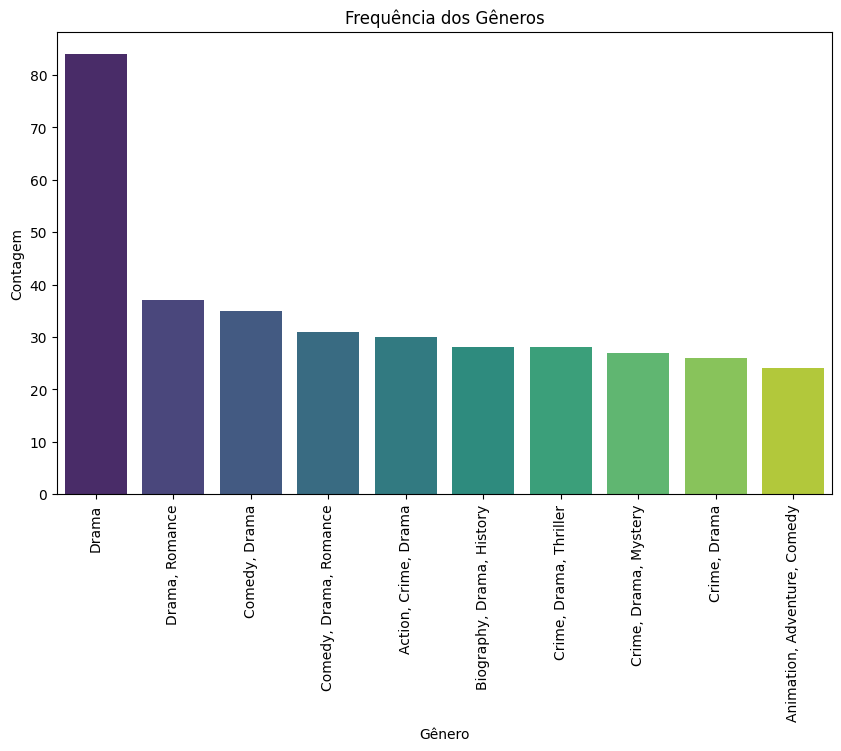

In [28]:
genre_counts = dados['Genre'].value_counts().head(10)

# Plot para a frequência dos Gêneros
plt.figure(figsize=(10, 6))
sns.barplot(x=genre_counts.index, y=genre_counts.values, palette='viridis')
plt.title('Frequência dos Gêneros')
plt.xlabel('Gênero')
plt.ylabel('Contagem')
plt.xticks(rotation=90)
plt.show()

##Análise bivariada e multivariada

### Matriz de correlação

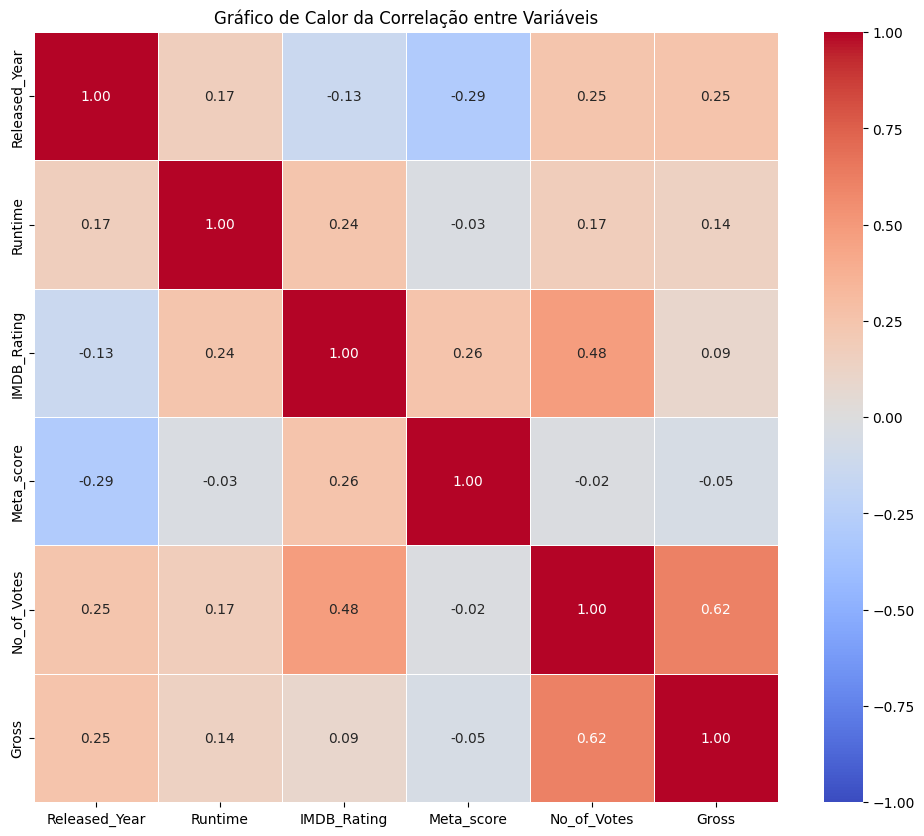

In [77]:
# Selecione apenas as variáveis numéricas do DataFrame
dados_numericos = dados.select_dtypes(include=['float64', 'int64'])

# Calcular a matriz de correlação
correlation_matrix = dados_numericos.corr()

# Criar o gráfico de calor
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5, fmt=".2f")
plt.title('Gráfico de calor da correlação entre variáveis')
plt.show()

### Hipótese: A presença de estrelas famosas interfere positivamente no IMDB rating e na receira bruta

In [34]:
# Contar quantos filmes cada ator participou
actor_counts = pd.concat([
    dados['Star1'],
    dados['Star2'],
    dados['Star3'],
    dados['Star4']
]).value_counts()

# Criar um DataFrame com os atores e o número de filmes
actor_df = pd.DataFrame({'Actor': actor_counts.index, 'Film_Count': actor_counts.values})

# Exibir os 10 atores mais frequentes
top_actors = actor_df.head(10)
print(top_actors)

# Lista dos top 10 atores mais frequentes
top_actors_list = top_actors['Actor'].tolist()

# Adicionar uma coluna indicando a presença de uma estrela famosa
dados['Has_Famous_Star'] = (
    dados['Star1'].isin(top_actors_list) |
    dados['Star2'].isin(top_actors_list) |
    dados['Star3'].isin(top_actors_list) |
    dados['Star4'].isin(top_actors_list)
)

               Actor  Film_Count
0     Robert De Niro          17
1          Al Pacino          13
2          Tom Hanks          13
3          Brad Pitt          12
4     Clint Eastwood          12
5         Matt Damon          11
6     Christian Bale          11
7  Leonardo DiCaprio          11
8      James Stewart          10
9      Michael Caine           9


Receita Bruta Média com Estrela Famosa: 8.046666666666667
Receita Bruta Média sem Estrela Famosa: 7.936730123180292
Estatística T: 3.943214493159148
Valor-p: 8.60230692662687e-05


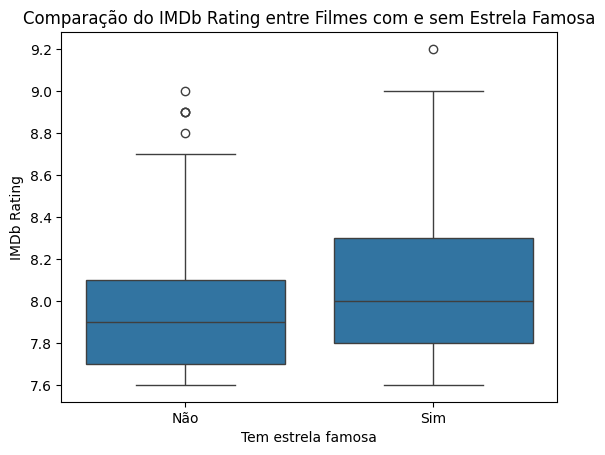

In [73]:
# Estatísticas de Receita Bruta para os dois grupos
imdb_com_famosos = dados[dados['Has_Famous_Star']]['IMDB_Rating'].mean()
imdb_sem_famosos = dados[~dados['Has_Famous_Star']]['IMDB_Rating'].mean()

print(f'Receita Bruta Média com Estrela Famosa: {imdb_com_famosos}')
print(f'Receita Bruta Média sem Estrela Famosa: {imdb_sem_famosos}')

# Teste T para comparar as médias
t_stat, p_value = stats.ttest_ind(
    dados[dados['Has_Famous_Star']]['IMDB_Rating'],
    dados[~dados['Has_Famous_Star']]['IMDB_Rating']
)

print(f'Estatística T: {t_stat}')
print(f'Valor-p: {p_value}')


# Boxplot para mostrar os resultados
sns.boxplot(x='Has_Famous_Star', y='IMDB_Rating', data=dados)
plt.title('Comparação do IMDb Rating entre Filmes com e sem Estrela Famosa')
plt.xlabel('Tem estrela famosa')
plt.ylabel('IMDb Rating')
plt.xticks([0, 1], ['Não', 'Sim'])
plt.show()


Receita Bruta Média com Estrela Famosa: 99760038.4
Receita Bruta Média sem Estrela Famosa: 51354865.10862262
Estatística T: 4.588741040774938
Valor-p: 5.027941382728743e-06


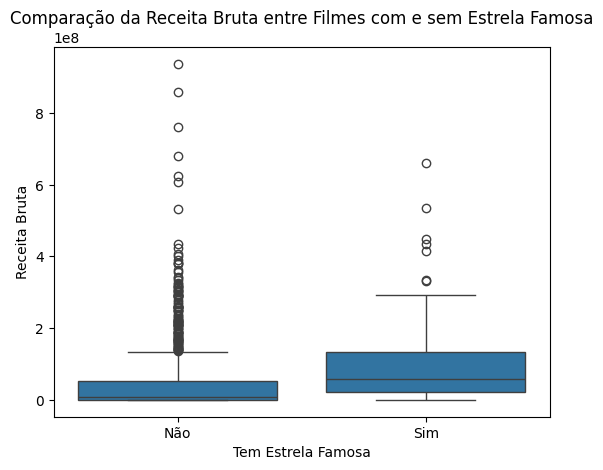

In [72]:
# Estatísticas de Receita Bruta para os dois grupos
gross_com_famosos = dados[dados['Has_Famous_Star']]['Gross'].mean()
gross_sem_famosos = dados[~dados['Has_Famous_Star']]['Gross'].mean()

print(f'Receita Bruta Média com Estrela Famosa: {gross_com_famosos}')
print(f'Receita Bruta Média sem Estrela Famosa: {gross_sem_famosos}')

# Teste T para comparar as médias de Receita Bruta
t_stat, p_value = stats.ttest_ind(
    dados[dados['Has_Famous_Star']]['Gross'],
    dados[~dados['Has_Famous_Star']]['Gross']
)

print(f'Estatística T: {t_stat}')
print(f'Valor-p: {p_value}')


sns.boxplot(x='Has_Famous_Star', y='Gross', data=dados)
plt.title('Comparação da Receita Bruta entre Filmes com e sem Estrela Famosa')
plt.xlabel('Tem Estrela Famosa')
plt.ylabel('Receita Bruta')
plt.xticks([0, 1], ['Não', 'Sim'])
plt.show()

A análise revelou que filmes com estrelas famosas têm uma receita bruta média de 99760038,40 reais, enquanto filmes sem estrelas famosas têm uma média de 51354865,11 reais. A Estatística T é 4.59 e o valor-p é baixo, indicando que essa diferença é estatisticamente significativa. Adicionalmente, os ratings de IMDb mostram uma diferença significativa, com filmes com estrelas famosas tendo uma média de 8.05 contra 7.94 para filmes sem estrelas famosas, com uma Estatística T de 3.94 e valor-p baixo. Portanto, a presença de estrelas famosas está associada a uma maior receita bruta e melhores notas no IMDb.

### Hipótese: A nota do IMDb é mais alta para filmes com maior receita bruta

Correlação entre IMDB Rating e Receita Bruta: 0.08633480133146906
Valor-p: 0.006350868687302881


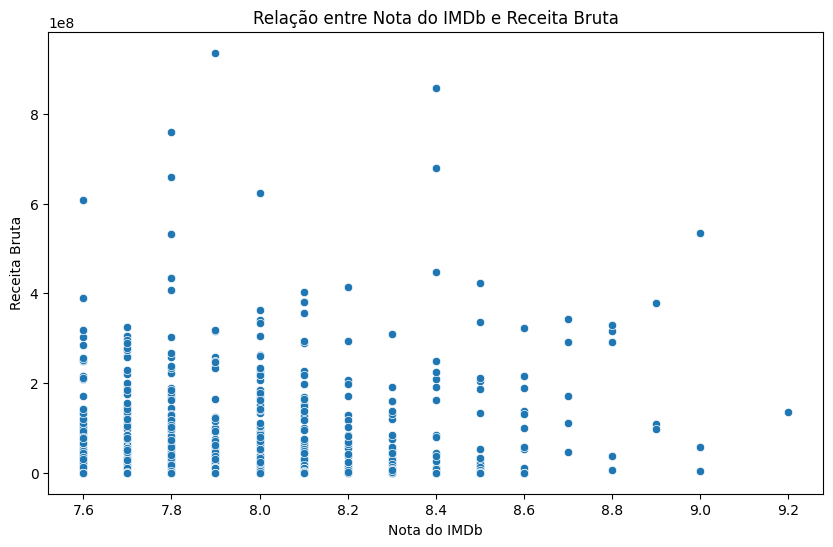

In [70]:
# Calcular a correlação entre IMDB_Rating e Gross
correlation, p_value = pearsonr(dados['IMDB_Rating'], dados['Gross'])

print(f'Correlação entre IMDB Rating e Receita Bruta: {correlation}')
print(f'Valor-p: {p_value}')


# Gráfico de dispersão para visualizar a relação entre IMDB Rating e Receita Bruta
plt.figure(figsize=(10, 6))
sns.scatterplot(x='IMDB_Rating', y='Gross', data=dados)
plt.title('Relação entre Nota do IMDb e Receita Bruta')
plt.xlabel('Nota do IMDb')
plt.ylabel('Receita Bruta')
plt.show()

A análise revelou uma correlação positiva de 0.086 entre a nota do IMDb e a receita bruta, com um valor-p de 0.0064. Embora a correlação seja estatisticamente significativa, ela é bastante fraca, indicando que não há uma forte relação entre uma nota alta no IMDb e uma maior receita bruta. Em outras palavras, a receita bruta não é um bom indicador da qualidade do filme segundo o IMDb.

### Hipótese: A categoria do certificado de idade influencia a receita média dos filmes

Estatística F: 27.20943723773415
Valor-p: 3.12549888996437e-12


<ipython-input-69-4f1eea89700a>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Certificate_Category', y='Gross', data=dados_avg_gross, palette='viridis')


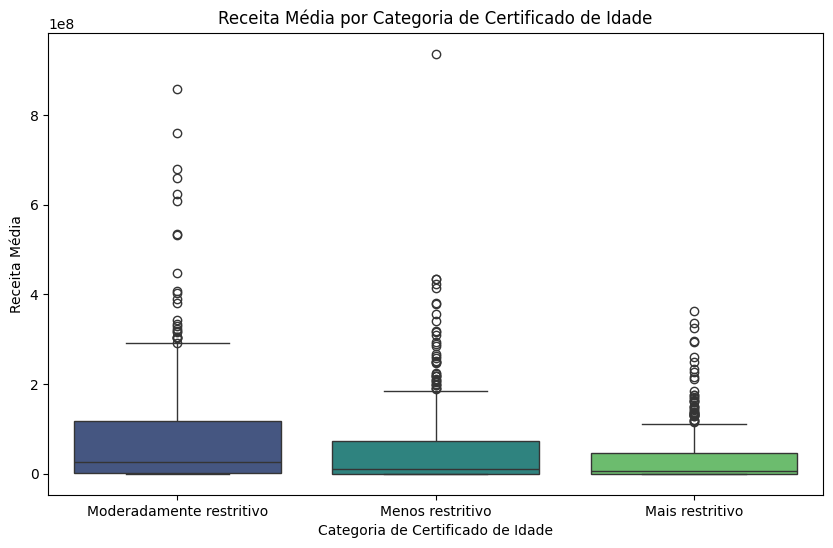

In [69]:
# Criar uma coluna para a categoria de certificado de idade
def categorize_certificate(certificate):
    if certificate in ['G', 'U', 'Passed', 'Approved']:
        return 'Menos restritivo'
    elif certificate in ['PG', 'PG-13', 'UA', 'U/A']:
        return 'Moderadamente restritivo'
    else:
        return 'Mais restritivo'

dados['Certificate_Category'] = dados['Certificate'].apply(categorize_certificate)

# Calcular a receita média por título de filme
average_gross = dados.groupby('Series_Title')['Gross'].mean().reset_index()

# Mesclar a receita média com o dataset original para obter as categorias de certificados
dados_avg_gross = pd.merge(average_gross, dados[['Series_Title', 'Certificate_Category']].drop_duplicates(), on='Series_Title')

# ANOVA para receita média por categoria de certificado de idade
categories = dados_avg_gross['Certificate_Category'].unique()
certificate_groups = [dados_avg_gross[dados_avg_gross['Certificate_Category'] == category]['Gross'] for category in categories]
f_stat, p_value = f_oneway(*certificate_groups)

print(f'Estatística F: {f_stat}')
print(f'Valor-p: {p_value}')

# Visualização
plt.figure(figsize=(10, 6))
sns.boxplot(x='Certificate_Category', y='Gross', data=dados_avg_gross, palette='viridis')
plt.title('Receita Média por Categoria de Certificado de Idade')
plt.xlabel('Categoria de Certificado de Idade')
plt.ylabel('Receita Média')
plt.show()

A ANOVA revelou uma diferença significativa na receita média entre as categorias de certificado de idade, com uma Estatística F de 27.21 e um Valor-p baixo. Filmes com categorias de certificado "Moderadamente Restritivo" têm uma receita média maior do que aqueles com "Menos Restritivo", que por sua vez têm uma receita média maior do que os filmes com "Mais Restritivo". Isso indica que a categoria do certificado de idade influencia a receita média dos filmes, mostrando que categorias menos restritivas têm, em média, receitas mais altas.



### Hipótese: Filmes lançados mais recentemente têm notas no IMDb mais altas

Correlação entre Ano de Lançamento e Nota no IMDb: -0.1332574408613115
Valor-p: 2.4072213864759086e-05


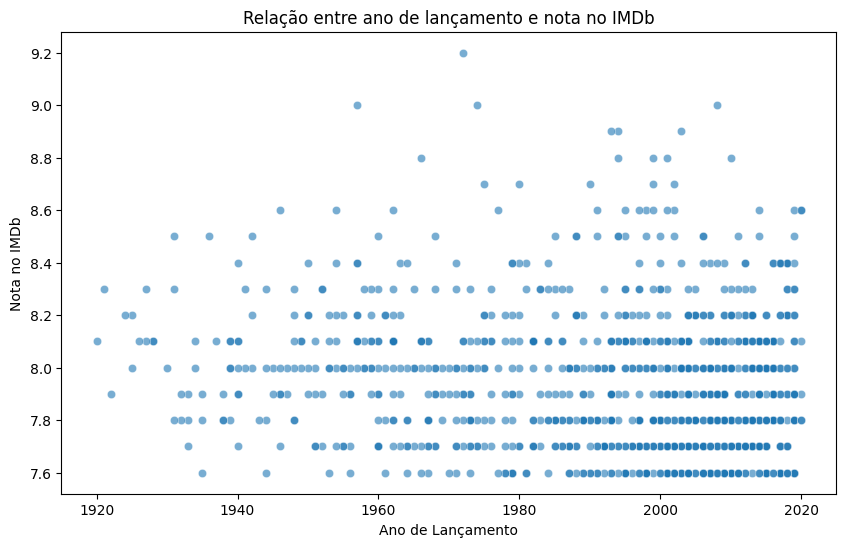

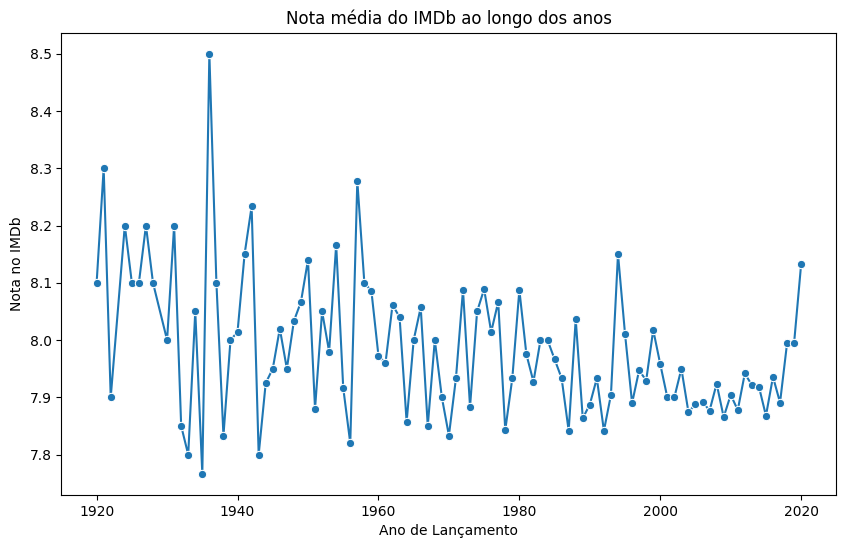

In [45]:
# Verificar a relação entre o ano de lançamento e as notas no IMDb
correlation, p_value = pearsonr(dados['Released_Year'], dados['IMDB_Rating'])

print(f'Correlação entre Ano de Lançamento e Nota no IMDb: {correlation}')
print(f'Valor-p: {p_value}')

# Visualização
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Released_Year', y='IMDB_Rating', data=dados, alpha=0.6)
plt.title('Relação entre ano de lançamento e nota no IMDb')
plt.xlabel('Ano de Lançamento')
plt.ylabel('Nota no IMDb')
plt.show()

# Cálculo da média das notas no IMDb por ano de lançamento
yearly_ratings = dados.groupby('Released_Year')['IMDB_Rating'].mean()

# Visualização da média das notas no IMDb ao longo dos anos
plt.figure(figsize=(10, 6))
sns.lineplot(x=yearly_ratings.index, y=yearly_ratings.values, marker='o')
plt.title('Nota média do IMDb ao longo dos anos')
plt.xlabel('Ano de Lançamento')
plt.ylabel('Nota no IMDb')
plt.show()

A correlação é ligeiramente negativa (-0.133), o que sugere uma fraca relação inversa entre o ano de lançamento e as notas no IMDb. Isso significa que, de acordo com os dados, filmes lançados mais recentemente tendem a ter notas ligeiramente mais baixas no IMDb. O valor-p é extremamente baixo, indicando que a correlação observada é estatisticamente significativa. Com base na análise, a hipótese de que "filmes lançados mais recentemente têm notas no IMDb mais altas" não é suportada pelos dados.

### Hipótese: O gênero do filme tem influência no IMDB

In [110]:
# Dividir os gêneros combinados em gêneros individuais
df_genres = dados.copy()
df_genres['Genre'] = df_genres['Genre'].str.split(', ')
df_genres = df_genres.explode('Genre')

# Agrupando por gênero e calculando a média da nota do IMDb para cada gênero
genre_rating_means = df_genres.groupby('Genre')['IMDB_Rating'].mean()
print(genre_rating_means)

# Preparando os dados para o teste ANOVA
# Agrupando as notas por gênero
genre_groups = df_genres.groupby('Genre')['IMDB_Rating'].apply(list)

# Realizando o teste ANOVA
f_stat, p_value = stats.f_oneway(*genre_groups)

print(f'Estatística F: {f_stat:.2f}')
print(f'Valor-p: {p_value:.4f}')

Genre
Action       7.948677
Adventure    7.953846
Animation    7.930488
Biography    7.935780
Comedy       7.903433
Crime        7.954545
Drama        7.958033
Family       7.912500
Fantasy      7.931818
Film-Noir    7.989474
History      7.960000
Horror       7.887500
Music        7.914286
Musical      7.947059
Mystery      7.967677
Romance      7.925600
Sci-Fi       7.977612
Sport        7.926316
Thriller     7.909489
War          8.013725
Western      8.000000
Name: IMDB_Rating, dtype: float64
Estatística F: 1.02
Valor-p: 0.4313


Dado que o valor-p é 0.4313, que é maior do que 0.05, não rejeitamos a hipótese nula. Isso significa que, com base nos dados disponíveis, não há evidências suficientes para afirmar que o gênero do filme influencia significativamente a nota do IMDb.



### Hipótese: Filmes com uma duração moderada (entre 90 e 120 minutos) tendem a gerar mais receita

Estatística F: 10.970089058777889
Valor-p: 1.9387335064035056e-05


<ipython-input-55-f86fa00ae55d>:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Runtime_Category', y='Gross', data=dados, palette='viridis')


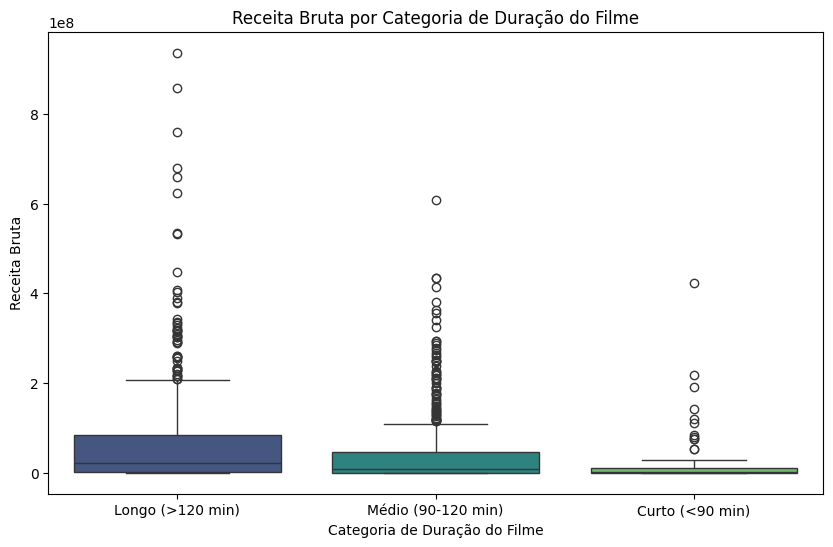

In [55]:
# Categorizar os filmes em diferentes intervalos de duração
def categorize_runtime(runtime):
    if runtime < 90:
        return 'Curto (<90 min)'
    elif 90 <= runtime <= 120:
        return 'Médio (90-120 min)'
    else:
        return 'Longo (>120 min)'

dados['Runtime_Category'] = dados['Runtime'].apply(categorize_runtime)

# Calcular a receita média por filme em cada categoria de duração
average_gross_per_category = dados.groupby('Runtime_Category')['Gross'].mean().reset_index()

# ANOVA para receita média por filme por categoria de duração
categories = dados['Runtime_Category'].unique()
runtime_groups = [dados[dados['Runtime_Category'] == category]['Gross'] for category in categories]
f_stat, p_value = f_oneway(*runtime_groups)

print(f'Estatística F: {f_stat}')
print(f'Valor-p: {p_value}')

# Visualização com Boxplot para Receita Média por Categoria de Duração
plt.figure(figsize=(10, 6))
sns.boxplot(x='Runtime_Category', y='Gross', data=dados, palette='viridis')
plt.title('Receita Bruta por Categoria de Duração do Filme')
plt.xlabel('Categoria de Duração do Filme')
plt.ylabel('Receita Bruta')
plt.show()

O gráfico indicou que filmes longos têm uma receita média maior do que filmes de duração média, e filmes de duração média têm uma receita média maior do que filmes curtos. O valor-p muito baixo indica que há uma diferença significativa entre as médias das receitas das diferentes categorias de duração. A estatística F sugere que as diferenças entre as médias dos grupos são mais pronunciadas do que as diferenças dentro dos grupos, reforçando a ideia de que as categorias de duração têm efeitos distintos sobre a receita dos filmes.

### Hipótese: Diretores famosos tendem a gerar mais receita

            Director  Film_Count
0   Alfred Hitchcock          14
1   Steven Spielberg          13
2     Hayao Miyazaki          11
3     Akira Kurosawa          10
4    Martin Scorsese          10
5    Stanley Kubrick           9
6       Billy Wilder           9
7        Woody Allen           9
8  Christopher Nolan           8
9     Clint Eastwood           8
Estatística T: 0.5108285909194842
Valor-p: 0.61038719691905


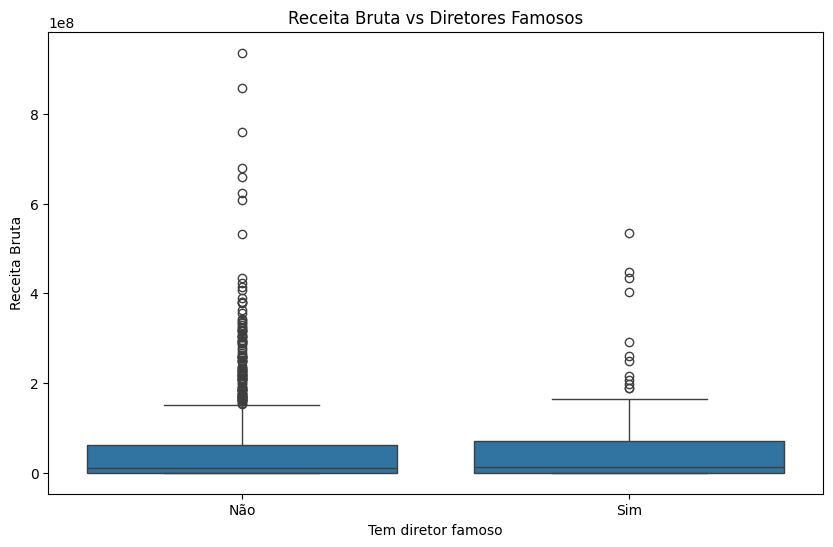

In [60]:
# Contar quantos filmes cada diretor dirigiu

director_counts = dados['Director'].value_counts()

# Criar um DataFrame com os diretores e o número de filmes
director_df = pd.DataFrame({'Director': director_counts.index, 'Film_Count': director_counts.values})

# Exibir os 10 diretores mais frequentes
top_directors = director_df.head(10)
print(top_directors)  # Lista dos top 10 diretores mais frequentes
top_directors_list = top_directors['Director'].tolist()

# Adicionar uma coluna indicando a presença de um diretor famoso
dados['Has_Famous_Director'] = dados['Director'].isin(top_directors_list)

# Teste T para comparar as médias
t_stat, p_value = stats.ttest_ind(
    dados[dados['Has_Famous_Director']]['Gross'],
    dados[~dados['Has_Famous_Director']]['Gross'],
    equal_var=False
)

print(f'Estatística T: {t_stat}')
print(f'Valor-p: {p_value}')

# Boxplot para mostrar a relação entre diretores famosos e receita bruta
plt.figure(figsize=(10, 6))
sns.boxplot(x='Has_Famous_Director', y='Gross', data=dados)
plt.title('Receita Bruta vs Diretores Famosos')
plt.xlabel('Tem diretor famoso')
plt.ylabel('Receita Bruta')
plt.xticks([0, 1], ['Não', 'Sim'])
plt.show()

A estatística T calculada foi 0,511 e o valor-p foi 0,610. Como o valor-p é maior que 0,05, concluímos que não há uma diferença significativa na receita bruta média entre filmes com diretores famosos e filmes sem diretores famosos. Isso significa que, com base nos dados, a fama do diretor não parece influenciar a receita dos filmes.

### Hipótese: Filmes com mais votos têm uma receita bruta maior.

Correlação: 0.6167524366922656
Valor-p: 1.2277272468434561e-105


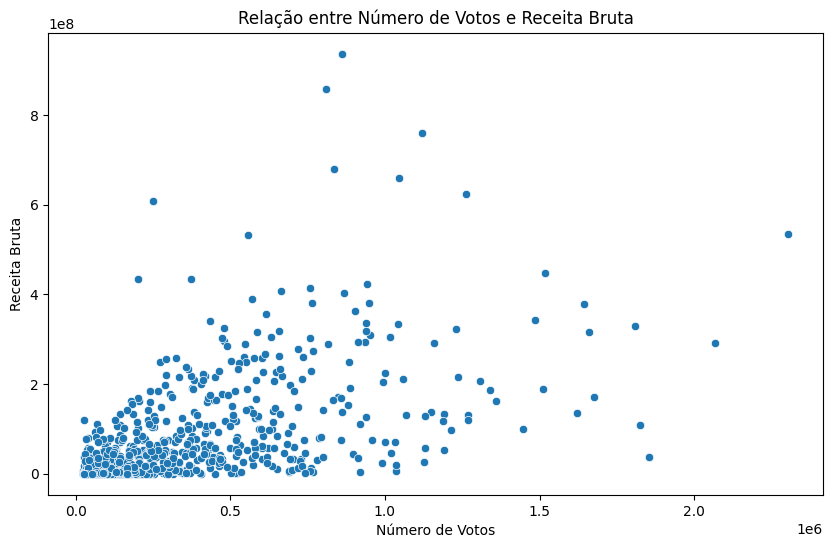

In [61]:
# Calcular a correlação
correlation, p_value = pearsonr(dados['No_of_Votes'], dados['Gross'])

print(f'Correlação: {correlation}')
print(f'Valor-p: {p_value}')

# Gráfico de dispersão para visualizar a relação entre número de votos e receita bruta
plt.figure(figsize=(10, 6))
sns.scatterplot(x='No_of_Votes', y='Gross', data=dados)
plt.title('Relação entre Número de Votos e Receita Bruta')
plt.xlabel('Número de Votos')
plt.ylabel('Receita Bruta')
plt.show()

A correlação entre o número de votos e a receita bruta dos filmes é 0,617, o que indica uma relação positiva moderada a forte. Isso significa que, geralmente, filmes com mais votos no IMDb tendem a gerar mais receita bruta. O valor-p extremamente baixo confirma que essa correlação é estatisticamente significativa e não é um resultado aleatório.

### Hipótese: Existem diferenças significativas na receita media entre diferentes gêneros de filmes


      Series_Title  Released_Year Certificate  Runtime   Genre  IMDB_Rating  \
0    The Godfather           1972           A      175   Crime          9.2   
0    The Godfather           1972           A      175   Drama          9.2   
1  The Dark Knight           2008          UA      152  Action          9.0   
1  The Dark Knight           2008          UA      152   Crime          9.0   
1  The Dark Knight           2008          UA      152   Drama          9.0   

                                            Overview  Meta_score  \
0  An organized crime dynasty's aging patriarch t...       100.0   
0  An organized crime dynasty's aging patriarch t...       100.0   
1  When the menace known as the Joker wreaks havo...        84.0   
1  When the menace known as the Joker wreaks havo...        84.0   
1  When the menace known as the Joker wreaks havo...        84.0   

               Director           Star1         Star2          Star3  \
0  Francis Ford Coppola   Marlon Brando     

<ipython-input-109-1042091dd3aa>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Gross', y='Genre', data=df_genres, palette='viridis')


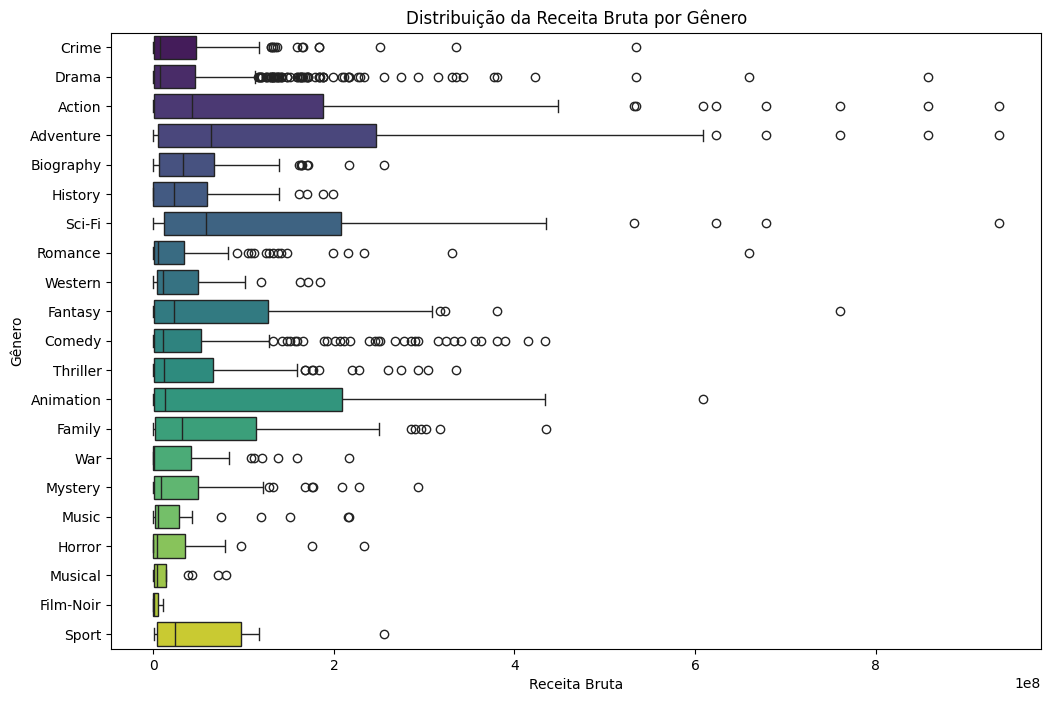

In [109]:
# Mostrar as primeiras linhas do dataframe após a divisão dos gêneros
print(df_genres.head())

# Calcular a receita média por gênero
genre_revenue_avg = df_genres.groupby('Genre')['Gross'].mean().reset_index()
genre_revenue_avg.columns = ['Genre', 'Average_Gross']

# Exibir a receita média por gênero
print(genre_revenue_avg)

# Teste ANOVA para receita média por gênero
genres = df_genres['Genre'].unique()
genre_groups = [df_genres[df_genres['Genre'] == genre]['Gross'] for genre in genres]

f_stat, p_value = f_oneway(*genre_groups)

print(f'Estatística F: {f_stat}')
print(f'Valor-p: {p_value}')

# Gráfico de Boxplot para receita bruta por gênero
plt.figure(figsize=(12, 8))
sns.boxplot(x='Gross', y='Genre', data=df_genres, palette='viridis')

# Adicionar título e rótulos aos eixos
plt.title('Distribuição da Receita Bruta por Gênero')
plt.xlabel('Receita Bruta')
plt.ylabel('Gênero')

# Exibir o gráfico
plt.show()

A análise revelou uma diferença significativa na receita média entre gêneros. Gêneros como Adventure, Action e Sci-Fi têm receitas médias mais altas, enquanto Film-Noir e Musical apresentam receitas mais baixas. O boxplot mostra que gêneros populares geralmente geram mais receita.

## Qual filme você recomendaria para uma pessoa que você não conhece?

In [75]:
# Filtrar filmes com estrela famosa e nota IMDb alta
high_rated_famous_star_movies = dados[(dados['Has_Famous_Star']) & (dados['IMDB_Rating'] > 9.0)]

# Ordenar por Receita Bruta em ordem decrescente
top_revenue_movies = high_rated_famous_star_movies.sort_values(by='Gross', ascending=False)

# Exibir o filme com a maior Receita Bruta
top_recommendation = top_revenue_movies[['Series_Title', 'IMDB_Rating', 'Gross']].head(1)
print(top_recommendation)



    Series_Title  IMDB_Rating        Gross
0  The Godfather          9.2  134966411.0


Com base nas análises dos dados, recomendaria "The Godfather" para uma pessoa sem conhecer suas preferências pessoais. Este filme é uma escolha excelente porque possui uma nota IMDb alta de 9.2 e conta com a presença de uma estrela famosa, o que sugere uma alta qualidade de produção e uma grande aceitação tanto pela crítica quanto pelo público. Além disso, "The Dark Knight" gerou uma receita bruta alta, confirmando seu sucesso financeiro.

## Quais são os principais fatores que estão relacionados com alta expectativa de faturamento de um filme?

Filmes com estrela famosa, número de votos maior, gênero do filme (como Ação e Aventura), duração do filme longa, filmes com certificado moderadamente restritivos.


## Quais insights podem ser tirados com a coluna Overview? É possível inferir o gênero do filme a partir dessa coluna?

Para inferir o gênero a partir do overview do filme, é possível usar a frequência das palavras mais comuns em descrições de filmes de diferentes gêneros e calcular a similaridade do cosseno entre o vetor do overview e os vetores dos gêneros baseados nessas palavras.



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!



Genre: Crime
Most Common Words: {'two': 29, 'young': 25, 'man': 24, 'crime': 20, 'one': 20, 'murder': 20, 'police': 19, 'family': 17, 'life': 14, 'story': 14}

Genre: Drama
Most Common Words: {'young': 99, 'man': 95, 'life': 89, 'two': 73, 'world': 60, 'story': 57, 'war': 55, 'woman': 55, 'new': 49, 'love': 48}

Genre: Action
Most Common Words: {'must': 22, 'two': 19, 'young': 19, 'one': 15, 'world': 14, 'man': 14, 'war': 13, 'find': 13, 'former': 12, 'family': 12}

Genre: Adventure
Most Common Words: {'young': 30, 'world': 29, 'new': 18, 'must': 18, 'family': 15, 'find': 15, 'boy': 15, 'war': 14, 'man': 13, 'help': 12}

Genre: Biography
Most Common Words: {'story': 29, 'life': 20, 'man': 14, 'war': 10, 'world': 9, 'american': 8, 'ii': 7, 'becomes': 7, 'true': 7, 'one': 6}

Genre: History
Most Common Words: {'war': 13, 'life': 9, 'world': 7, 'ii': 7, 'story': 7, 'king': 6, 'german': 6, 'british': 6, 'man': 5, 'american': 5}

Genre: Sci-Fi
Most Common Words: {'life': 10, 'must': 10, 'f

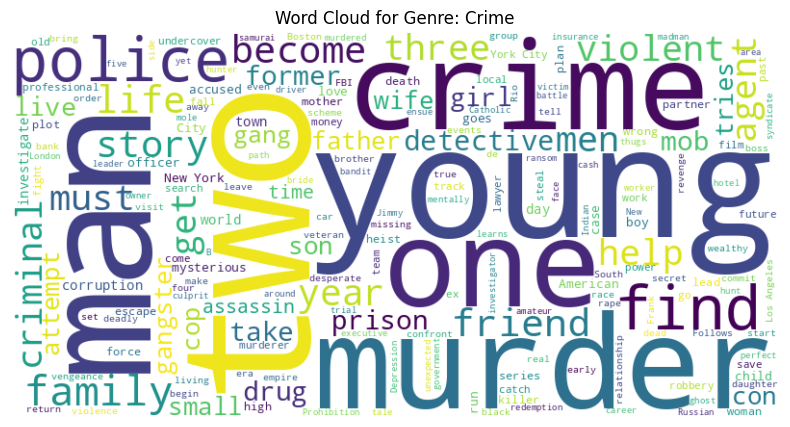

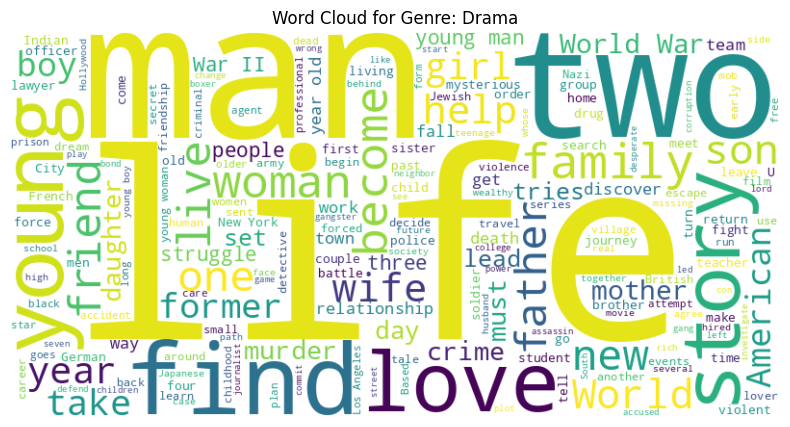

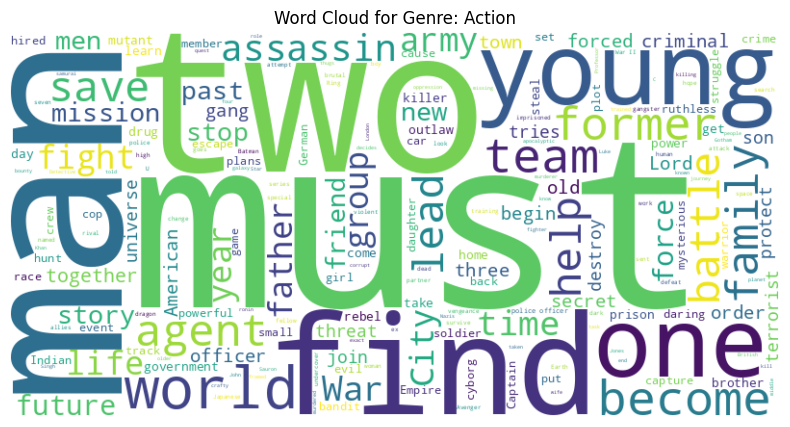

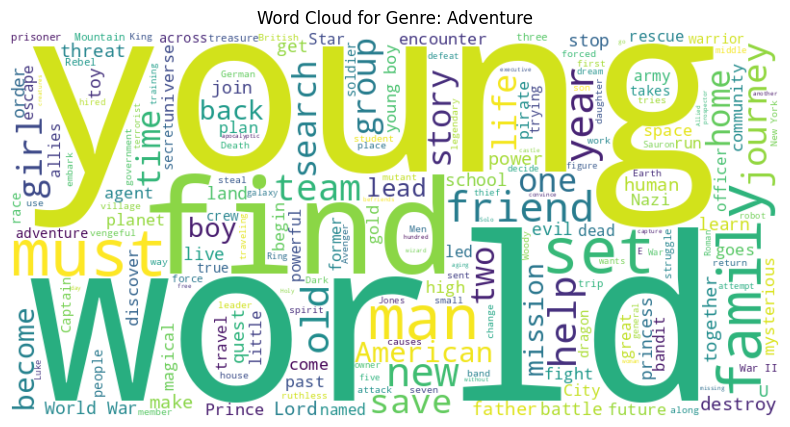

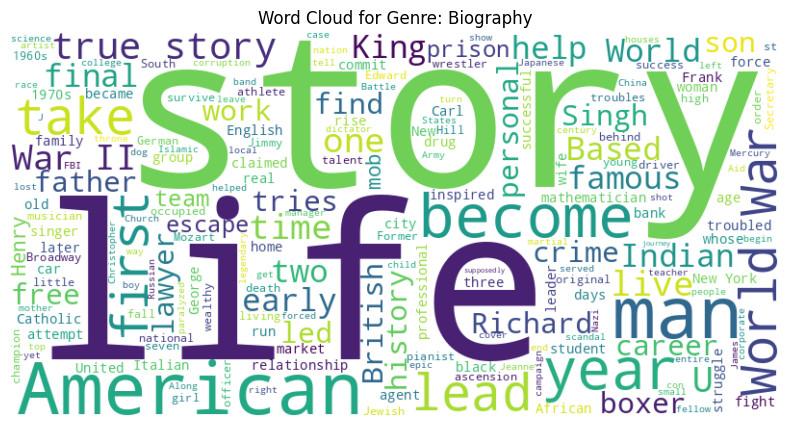

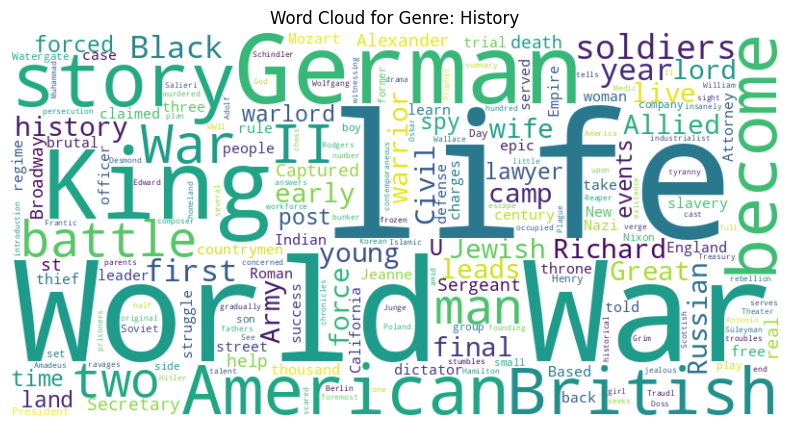

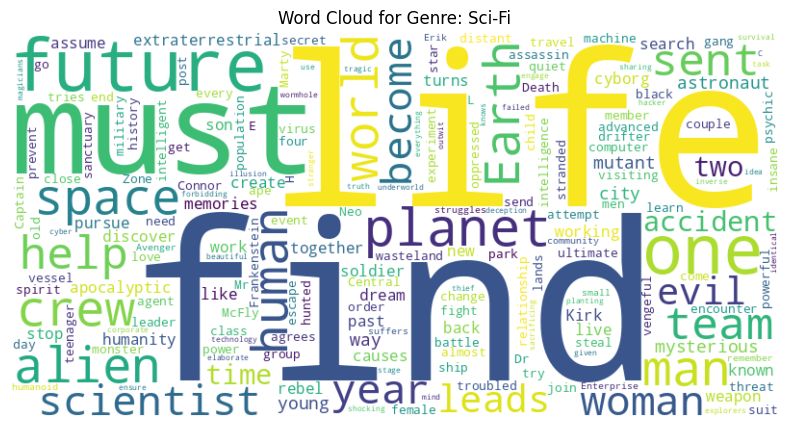

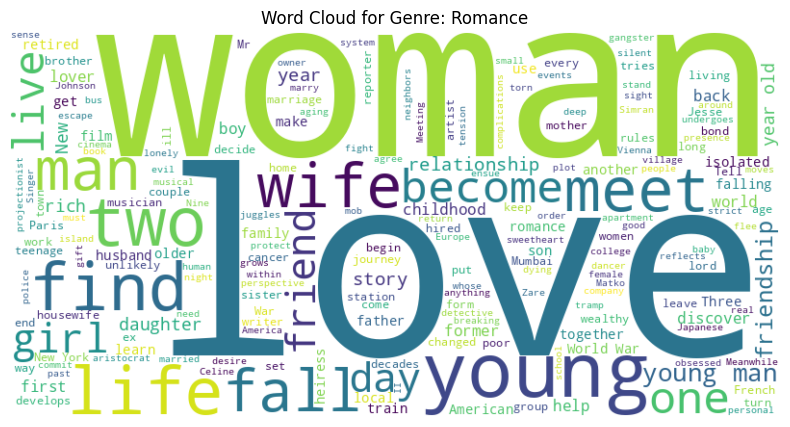

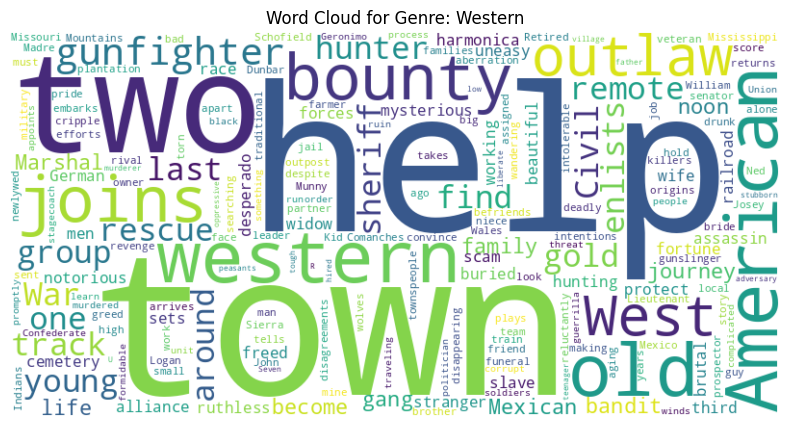

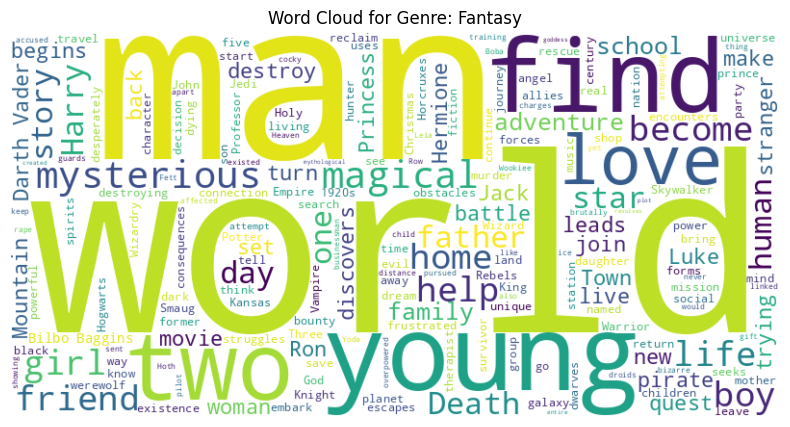

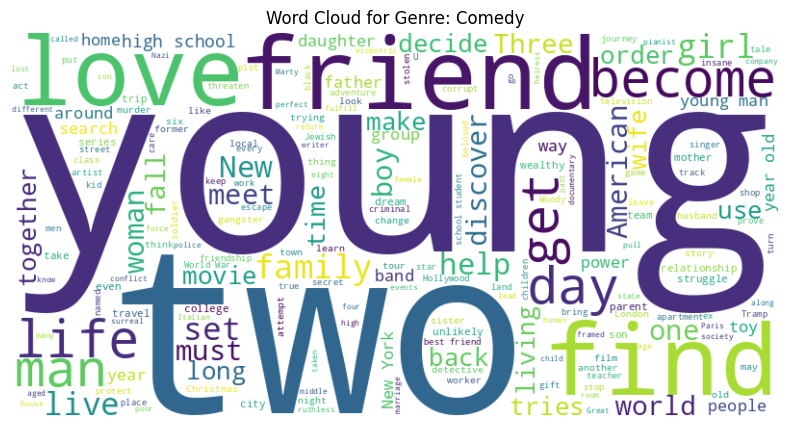

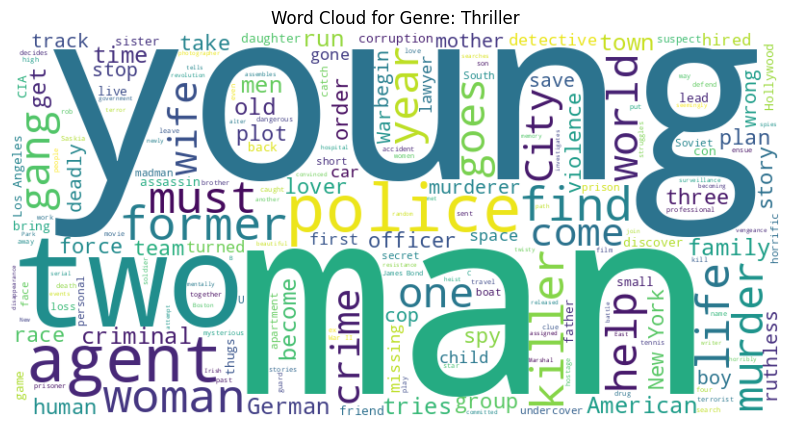

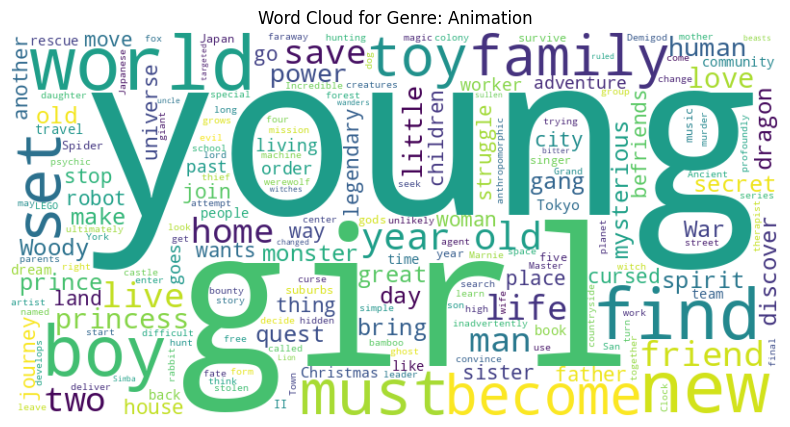

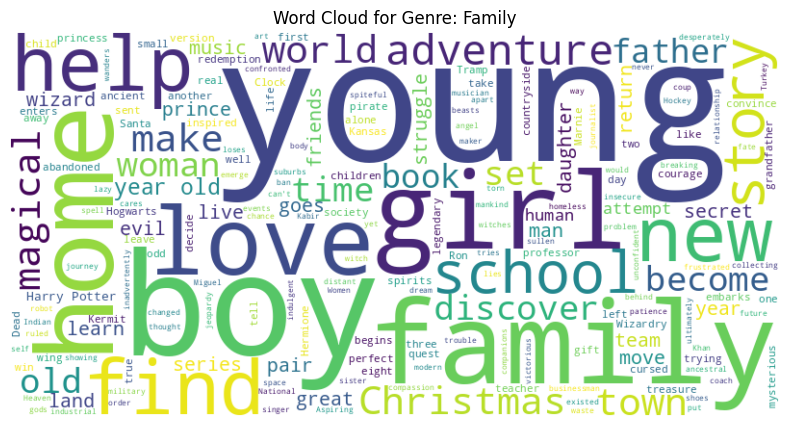

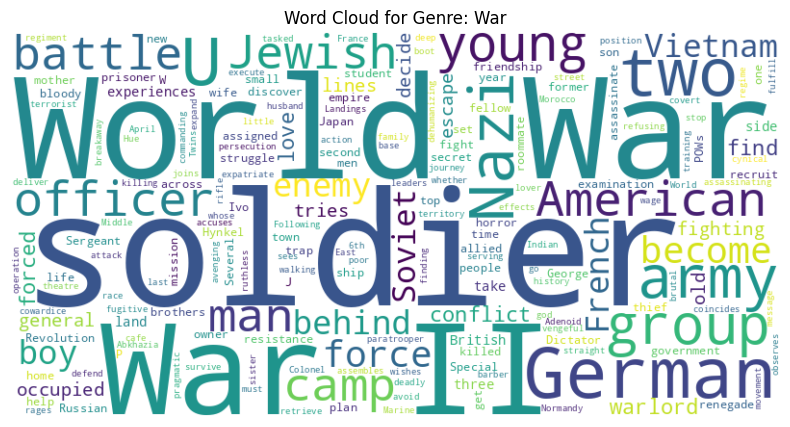

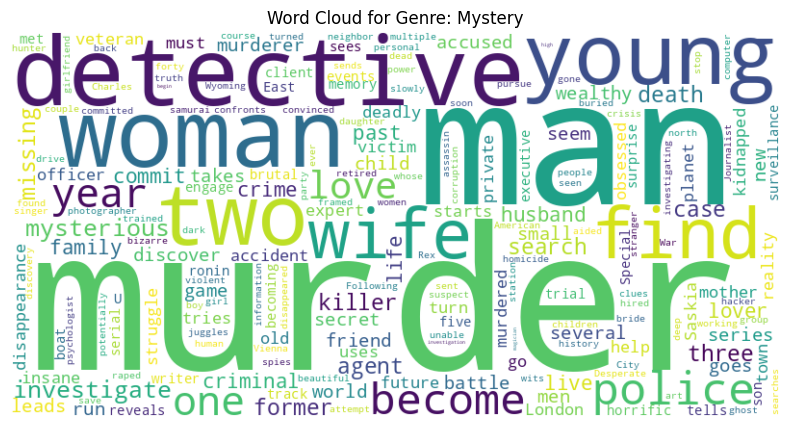

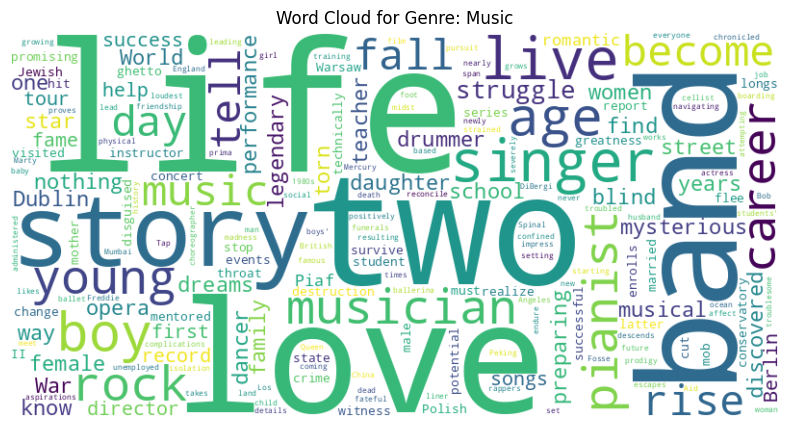

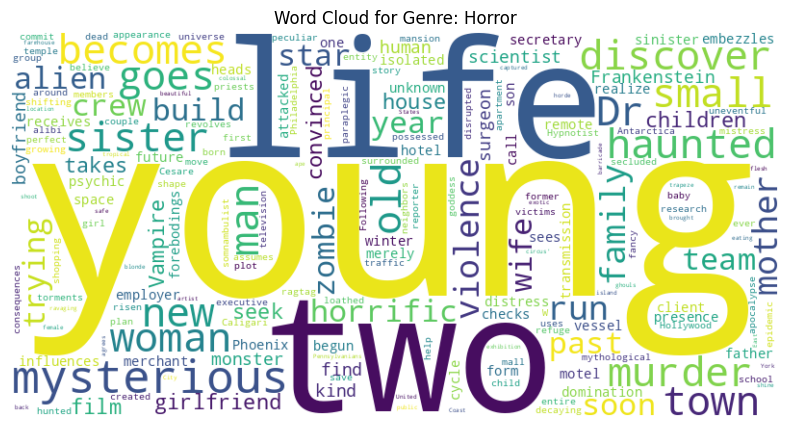

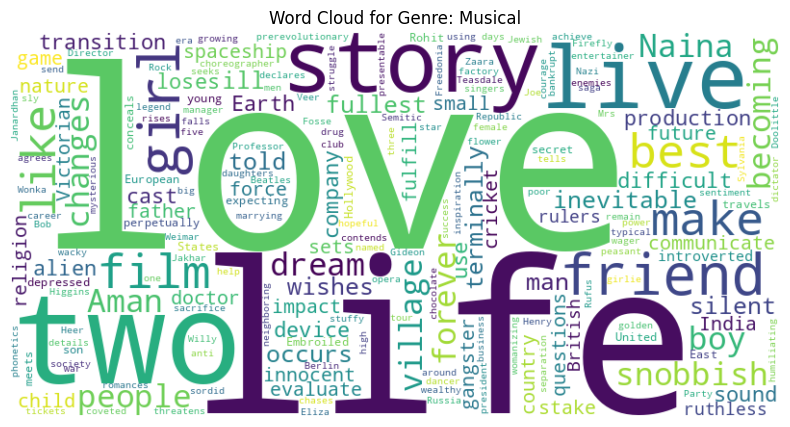

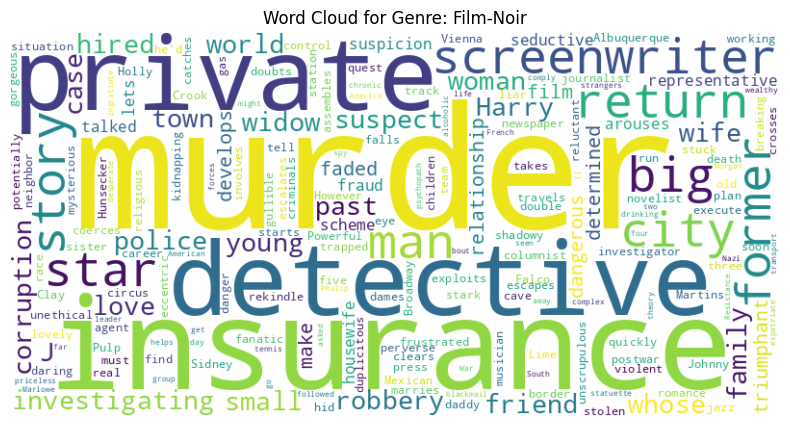

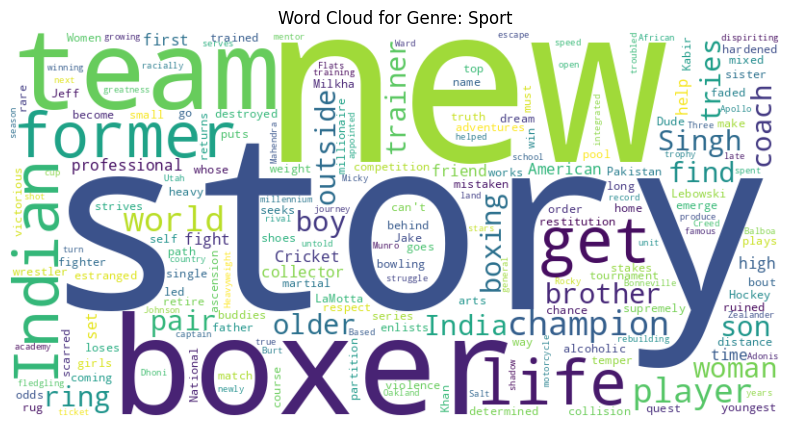


Predicted Genre for the Overview: Crime


In [136]:
# Baixar pacotes necessários
nltk.download('punkt')
nltk.download('stopwords')

# Função para obter as palavras mais frequentes por gênero
def get_most_common_words_by_genre(df, top_n=10):
    stop_words = set(stopwords.words('english'))
    genre_word_freq = {}

    for genre in df['Genre'].unique():
        genre_overview = ' '.join(df[df['Genre'] == genre]['Overview'].dropna())
        tokens = word_tokenize(genre_overview.lower())
        filtered_words = [word for word in tokens if word.isalpha() and word not in stop_words]
        word_freq = Counter(filtered_words)
        most_common_words = word_freq.most_common(top_n)
        genre_word_freq[genre] = dict(most_common_words)  # Corrigido para ser um dict

    return genre_word_freq

# Obter as palavras mais frequentes por gênero
genre_word_freq = get_most_common_words_by_genre(df_genres)
for genre, words in genre_word_freq.items():
    print(f'\nGenre: {genre}')
    print('Most Common Words:', words)

# Função para plotar nuvens de palavras por gênero
def plot_wordcloud_by_genre(df):
    stop_words = set(stopwords.words('english'))
    genres = df['Genre'].unique()

    for genre in genres:
        genre_overview = ' '.join(df[df['Genre'] == genre]['Overview'].dropna())
        wordcloud = WordCloud(stopwords=stop_words, background_color='white', width=800, height=400).generate(genre_overview)

        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f'Word Cloud for Genre: {genre}')
        plt.show()

# Visualizar nuvens de palavras por gênero
plot_wordcloud_by_genre(df_genres)

# Função para prever o gênero com base no overview
def predict_genre_from_overview(overview, genre_word_freq):
    # Tokenizar e limpar o texto do overview
    overview_words = preprocess_text(overview)
    overview_counter = Counter(overview_words)

# Criar uma matriz de características
    all_words = set()
    for word_freq in genre_word_freq.values():
        all_words.update(word_freq.keys())

    all_words = list(all_words)
    genre_vectors = {genre: np.zeros(len(all_words)) for genre in genre_word_freq}

    for genre, word_freq in genre_word_freq.items():
        for i, word in enumerate(all_words):
            genre_vectors[genre][i] = word_freq.get(word, 0)

    overview_vector = np.zeros(len(all_words))
    for i, word in enumerate(all_words):
        overview_vector[i] = overview_counter.get(word, 0)

    # Calcular a similaridade do cosseno
    similarities = {}
    for genre, vector in genre_vectors.items():
        similarities[genre] = cosine_similarity([overview_vector], [vector])[0][0]

    # Retorna o gênero com a maior similaridade
    best_genre = max(similarities, key=similarities.get)
    return best_genre

# Função para processar o texto (usada também na previsão do gênero)
def preprocess_text(text):
    tokens = word_tokenize(text.lower())
    filtered_words = [word for word in tokens if word.isalpha() and word not in stopwords.words('english')]
    return filtered_words

# Exemplo de uso da função de previsão
example_overview = "Two imprisoned men bond over a number of years, finding solace and eventual redemption through acts of common decency."
predicted_genre = predict_genre_from_overview(example_overview, genre_word_freq)
print(f'\nPredicted Genre for the Overview: {predicted_genre}')


A análise de sentimento classifica o sentimento expresso em textos, gerando uma pontuação que indica se o sentimento é positivo ou negativo. No contexto dos gêneros de filmes, a tabela abaixo mostra a média dos sentimentos dos resumos de filmes para cada gênero, revelando se um gênero tende a ter sentimentos mais positivos ou negativos em suas descrições.

In [135]:
# Aplicar análise de sentimento
df_genres['Sentiment'] = df_genres['Overview'].dropna().apply(lambda x: TextBlob(x).sentiment.polarity)
print(df_genres[['Sentiment', 'Genre']].groupby('Genre').mean())


           Sentiment
Genre               
Action     -0.041751
Adventure   0.017182
Animation   0.056954
Biography   0.043308
Comedy      0.033003
Crime      -0.020389
Drama       0.014153
Family      0.076655
Fantasy     0.013867
Film-Noir   0.023325
History     0.024703
Horror      0.006796
Music       0.144993
Musical     0.178908
Mystery    -0.014093
Romance     0.071517
Sci-Fi     -0.031734
Sport       0.027583
Thriller   -0.026413
War        -0.044084
Western    -0.065120


## Explique como você faria a previsão da nota do imdb a partir dos dados. Quais variáveis e/ou suas transformações você utilizou e por quê? Qual tipo de problema estamos resolvendo (regressão, classificação)? Qual modelo melhor se aproxima dos dados e quais seus prós e contras? Qual medida de performance do modelo foi escolhida e por quê?


Estamos resolvendo um problema de regressão. O objetivo é prever uma variável contínua, a nota do IMDb, a partir de um conjunto de características dos filmes.


Variáveis categóricas que mostraram influência no teste de hipótese

*   Tem Estrela Famosa (Has_Famous_Star): O teste de hipótese revelou que a presença de uma estrela famosa está fortemente correlacionada com uma nota mais alta no IMDb.

Variáveis numéricas que mostraram maiores correlações com IMDb na matriz de correlação

*   Duração do Filme (Runtime): 0.24
*   Meta_score (Meta_score): 0.26
*   Número de Votos no IMDb (No_of_Votes): 0.48

O RandomForestRegressor é o modelo que apresentou MSE.É um modelo eficiente para prever variáveis contínuas, como a nota do IMDb, devido à sua capacidade de capturar relações não lineares e interações complexas entre variáveis. A combinação de múltiplas árvores de decisão reduz o risco de overfitting e melhora a precisão das previsões. Além disso, o Random Forest lida bem com dados desbalanceados e é menos sensível a ruídos, proporcionando previsões mais confiáveis e estáveis. No entanto, o RandomForestRegressor pode ser mais lento para treinar e prever em comparação com modelos mais simples devido ao seu alto número de árvores e a complexidade dos cálculos envolvidos. Além disso, a interpretabilidade do modelo é limitada, pois é mais difícil entender a contribuição específica de cada variável para as previsões, ao contrário de modelos lineares mais transparentes. A métrica Mean Squared Error (MSE) foi escolhida para avaliar o desempenho do modelo porque ela penaliza grandes erros de previsão de forma quadrática, o que ajuda a identificar modelos que têm um desempenho ruim em termos de precisão. MSE é uma medida comum para problemas de regressão, pois fornece uma avaliação clara da magnitude dos erros de previsão e é diretamente relacionada ao desempenho geral do modelo.

In [140]:
# Selecionando as variáveis relevantes e incluindo Series_Title
df_prepared = df_genres[['Series_Title', 'IMDB_Rating', 'Runtime', 'No_of_Votes', 'Meta_score', 'Has_Famous_Star']]

# Garantir que cada Series_Title apareça apenas uma vez. Se houver duplicatas, mantenha a primeira ocorrência.
df_prepared = df_prepared.drop_duplicates(subset=['Series_Title'])

# Transformando `No_of_Votes` com uma transformação logarítmica
df_prepared['No_of_Votes'] = df_prepared['No_of_Votes'].apply(lambda x: np.log(x + 1))

# Remover a coluna Series_Title após garantir que há apenas uma linha por título
df_prepared = df_prepared.drop(columns=['Series_Title'])

# Separação das variáveis independentes e dependentes
X = df_prepared.drop(columns=['IMDB_Rating'])
y = df_prepared['IMDB_Rating']


In [141]:
# Dividindo os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Inicializando o modelo
model = LinearRegression()

# Treinando o modelo
model.fit(X_train, y_train)

# Fazendo previsões
y_pred = model.predict(X_test)

# Avaliando o modelo
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Regressão Linear - MSE: {mse:.2f}')



Regressão Linear - MSE: 0.06


In [144]:
# Inicializando o modelo
model = DecisionTreeRegressor(random_state=42)

# Treinando o modelo
model.fit(X_train, y_train)

# Fazendo previsões
y_pred = model.predict(X_test)

# Avaliando o modelo
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Árvore de Decisão - MSE: {mse:.2f}')


Árvore de Decisão - MSE: 0.09


In [142]:
# Inicializando o modelo
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Treinando o modelo
model.fit(X_train, y_train)

# Fazendo previsões
y_pred = model.predict(X_test)

# Avaliando o modelo
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Random Forest - MSE: {mse:.2f}')


Random Forest - MSE: 0.05


## Supondo um filme com as seguintes características:

{'Series_Title': 'The Shawshank Redemption',
 'Released_Year': '1994',
 'Certificate': 'A',
 'Runtime': '142 min',
 'Genre': 'Drama',
 'Overview': 'Two imprisoned men bond over a number of years, finding solace and eventual redemption through acts of common decency.',
 'Meta_score': 80.0,
 'Director': 'Frank Darabont',
 'Star1': 'Tim Robbins',
 'Star2': 'Morgan Freeman',
 'Star3': 'Bob Gunton',
 'Star4': 'William Sadler',
 'No_of_Votes': 2343110,
 'Gross': '28,341,469'}


Qual seria a nota do IMDB?


In [116]:
joblib.dump(model, 'random_forest_model.pkl')

['random_forest_model.pkl']

In [119]:
# Dados do filme
new_data = {
    'Series_Title': 'The Shawshank Redemption',
    'Released_Year': '1994',
    'Certificate': 'A',
    'Runtime': '142 min',
    'Genre': 'Drama',
    'Overview': 'Two imprisoned men bond over a number of years, finding solace and eventual redemption through acts of common decency.',
    'Meta_score': 80.0,
    'Director': 'Frank Darabont',
    'Star1': 'Tim Robbins',
    'Star2': 'Morgan Freeman',
    'Star3': 'Bob Gunton',
    'Star4': 'William Sadler',
    'No_of_Votes': 2343110,
    'Gross': '28,341,469'
}

# Convertendo para um DataFrame
df_new = pd.DataFrame([new_data])

# Preparação do `Runtime` para ser um número inteiro
df_new['Runtime'] = df_new['Runtime'].str.replace(' min', '').astype(int)

# Transformando `No_of_Votes` com uma transformação logarítmica
df_new['No_of_Votes'] = np.log(df_new['No_of_Votes'] + 1)

# Transformando `Genre` em variáveis dummy (utilizando apenas as variáveis utilizadas para treinar o modelo)
df_new = pd.get_dummies(df_new, columns=['Genre'])

# Verificar se algum dos atores principais está na lista dos top_atores
df_new['Has_Famous_Star'] = int(any(actor in top_actors_list for actor in [df_new['Star1'][0], df_new['Star2'][0], df_new['Star3'][0], df_new['Star4'][0]]))

# Garantir que todas as variáveis categóricas e dummies do treinamento estejam presentes
# Adicionando uma coluna dummy para cada gênero que pode não estar presente no novo dado
for genre in X.columns:
    if genre.startswith('Genre_') and genre not in df_new.columns:
        df_new[genre] = 0

# Reordenar as colunas para que estejam na mesma ordem que as do conjunto de treinamento
# As colunas devem incluir: `Has_Famous_Star`, `Meta_score`, `Runtime`, `No_of_Votes`, e todas as variáveis dummy de `Genre`
df_new = df_new[X.columns.tolist()]

In [118]:
# Carregar o modelo treinado
model = joblib.load('random_forest_model.pkl')

# Fazer a previsão
predicted_rating = model.predict(df_new)

# Mostrar a previsão
print(f'A previsão da nota do IMDb para "{new_data["Series_Title"]}" é {predicted_rating[0]:.2f}')


A previsão da nota do IMDb para "The Shawshank Redemption" é 8.82
